In [129]:
#Básicos para manipulacion de datos 
import pandas as pd
import numpy as np
#Graficas 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set_theme()
#Optimización multiobjetivo 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.population import Population

#Finanzas 
import yfinance as yf
import yesg

#Plugins
from tqdm import tqdm
from itertools import compress
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras

In [130]:
assets = pd.read_csv('Indices/tickers_dowjones.csv', index_col=0)['0'].tolist()

In [131]:
ohlc = yf.download(assets, period="2y") 
prices = ohlc["Adj Close"].dropna(how="all")

[*********************100%***********************]  30 of 30 completed


In [132]:
prices.tail()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-27,188.059998,222.610001,168.190002,209.429993,240.690002,208.820007,50.860001,153.529999,89.059998,52.570000,...,113.320000,334.570007,113.610001,150.020004,172.589996,482.559998,227.339996,36.549999,28.639999,154.490005
2023-06-28,189.250000,221.309998,169.779999,210.720001,241.869995,212.169998,50.869999,154.919998,88.830002,52.959999,...,112.440002,335.850006,113.029999,149.990005,168.369995,474.450012,227.960007,36.820000,29.080000,155.330002
2023-06-29,189.589996,221.160004,172.080002,211.830002,244.240005,210.429993,51.209999,156.240005,88.949997,53.240002,...,113.540001,335.049988,113.370003,149.380005,170.990005,476.440002,234.320007,36.990002,28.370001,154.279999
2023-06-30,193.970001,222.020004,174.199997,211.160004,246.050003,211.259995,51.740002,157.350006,89.279999,53.259998,...,115.389999,340.540009,110.370003,151.740005,173.660004,480.640015,237.479996,37.189999,28.490000,157.179993
2023-07-03,192.460007,225.009995,175.440002,210.919998,247.330002,211.649994,51.820000,157.210007,90.500000,53.779999,...,114.330002,337.989990,109.110001,152.500000,173.089996,477.880005,237.970001,37.279999,29.020000,158.199997


In [133]:
returns, assets_info= pre_processing.get_assets_info(prices, 99, log_returns=True, drop_per_esg=True)
assets_info #Los rendimientos están con signo al revés 

100%|██████████| 30/30 [00:06<00:00,  4.77it/s]


,exp_risk,exp_return,esg_score
AAPL,0.296876,-0.158730,0.167
VZ,0.199888,0.153868,0.185
V,0.267590,-0.003891,0.161
UNH,0.229228,-0.090391,0.175
TRV,0.225834,-0.091054,0.205
PG,0.185414,-0.082554,0.266
NKE,0.344607,0.182707,0.170
MSFT,0.304332,-0.107827,0.152
MRK,0.221835,-0.223612,0.218
MMM,0.255001,0.292070,0.336


In [134]:
best_assets = ArchievingStrategies.get_best_opt(assets_info.iloc[:, :2], 1e-6)
best_assets

29it [00:00, 9671.21it/s]


,exp_risk,exp_return
MRK,0.221835,-0.223612
MCD,0.173243,-0.141173
KO,0.169437,-0.088946
JNJ,0.160148,-0.012666
CVX,0.283914,-0.247526


In [135]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(returns[best_assets.index], assets_info.loc[best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES)

In [136]:
def efficient_frontier_weights(ef, len_targets=100, targets=None):
        min_return = ef.mean_returns.min() *ef.freq
        max_return = ef.mean_returns.max() *ef.freq
        targets = np.linspace( np.round(min_return,8), np.round(max_return,8), len_targets)
        # compute the efficient frontier
        efrontier = []
        weights   = []
        for target in targets:
            x = ef.efficient_return(target, save_weights=False)
            weights.append(x)        
        X = np.array(weights)    
        return X

In [183]:
class DirectedSearch(): 
    def __init__(self, X, profits, risk,d, learn_rate=0.005, freq=252, n_iter=50): 
        self.X = X
        self.profits = profits 
        self.risk    = risk
        self.d       = d
        self.learn_rate = learn_rate
        self.freq    = freq 
        self.n_iter  = n_iter
    
    def evaluate_portf(self, x): 
        exp_return =  self.profits@x
        exp_risk    = np.sqrt(x.T@self.risk@x)
        return np.array([exp_risk, -exp_return])
    
    def jacob_portf(self, x): 
        #anualizados
        D_risk   = np.sqrt(self.freq)* (self.risk@x)/np.sqrt((x@self.risk@x))
        D_return = -self.freq*self.profits
        return np.vstack([D_risk, D_return])
    
    def gradient_descent(self, x): 
        x_new = x 
        Fx    = self.evaluate_portf(x)
        for _ in range(self.n_iter): 
            J = self.jacob_portf(x_new)
            Jinv = np.linalg.pinv(J)
            #print(Jinv)
            candidate = x_new +self.learn_rate*(Jinv@self.d)
            #Restricciones heurística de correción
            candidate[candidate<0]=0
            s= np.sum(candidate)
            candidate  = candidate/s
        
            if np.any((Fx- self.evaluate_portf(candidate)) > self.d): break
            else: x_new = candidate
        return x_new 
    
    
    def directed_search(self):
        weights = []
        for x in self.X: 
            weights.append(self.gradient_descent(x))   
        return np.array(weights)
    
    def directed_search_full_space(self, steps): 
        weights = self.directed_search()
        full_sample = []
        for x, x_eps in zip(self.X, weights): 
            for t in np.linspace(0, 1, steps): 
                full_sample.append((1-t)*x + t*x_eps)
        return np.array(full_sample)

500it [00:00, 5746.68it/s]


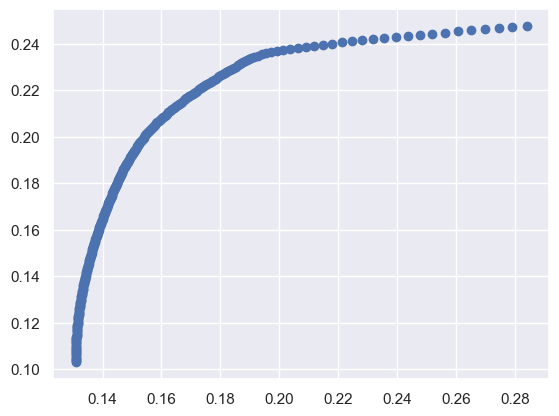

In [191]:
from finquant import efficient_frontier
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
X_ef = efficient_frontier_weights(ef, 500)
F_ef, ESG_ef = pymoo_extras.eval_weights(portfolio_problem, X_ef)
FA_ef =  pymoo_extras.annualised_portfolio_quantities(F_ef)
FA_ef_best = ArchievingStrategies.get_best_opt(FA_ef, 1e-6)
X_ef= X_ef[FA_ef_best.index]
plt.scatter(FA_ef_best['exp_risk'], -FA_ef_best['exp_return'])

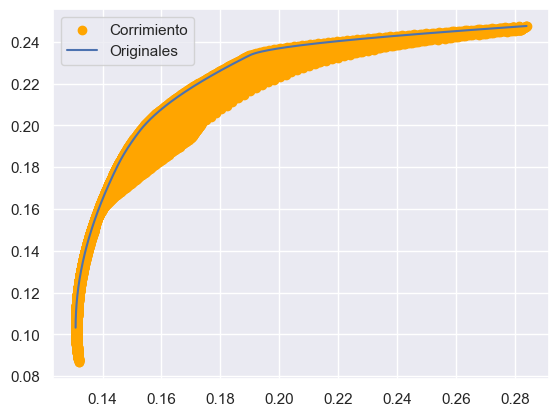

In [188]:
eps = np.array([0.01,0.01])
DS = DirectedSearch(X_ef[:], PROFITS, RISK, eps, learn_rate=0.001, n_iter=1000)
X_ef_new = DS.directed_search_full_space(20)
F_ef_new, ESG_ef_new = pymoo_extras.eval_weights(portfolio_problem, X_ef_new)
FA_ef_new =pymoo_extras.annualised_portfolio_quantities(F_ef_new)

plt.scatter(FA_ef_new['exp_risk'], -FA_ef_new['exp_return'], label='Corrimiento', color='orange')
plt.plot(FA_ef_best['exp_risk'], -FA_ef_best['exp_return'], label='Originales')
plt.legend()